In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Constants
#### From the Wiki

In [6]:
# Breaking Leaves
hand_leaf_time = 0.3
wood_hoe_leaf_time = 0.15
stone_hoe_leaf_time = 0.1

# Breaking Wood
hand_wood_time = 3
wood_axe_wood_time = 1.5
stone_axe_wood_time = 0.75

# Durability
wood_hoe_durability = 59
stone_hoe_durability = 131
wood_axe_durability = 60
stone_axe_durability = 132

tnt_fuse = 4

#### From Reddit

In [4]:
leaf_decay_prob = 15.0/1024

#### From My Testing

In [22]:
avg_leaves_per_tree = 55
craft_wood_hoe_time = 12
craft_2_wood_hoes_time = 12
craft_2_wood_axes_time = 12
craft_4_wood_hoes_time = 13
craft_6_wood_hoes_time = 14
time_between_tree_trunks = 4
time_to_make_stone_hoe = 30
time_to_make_stone_axe = 31
time_to_make_second_wood_hoe = 7 # when you already have 2 sticks in your inventory and you get 1 wood
time_to_make_extra_wood_hoes = 9 # when you already have 2 planks in your inventory and you get 1 wood
time_to_place_tnt = 7
leaves_broken_per_tnt = 50

## Math Functions

In [7]:
def expected_leaves_decayed(orig_num_leaves, t, p=leaf_decay_prob):
    """
    Arguments
    =========
    orig_num_leaves = the number of leaves on the tree before leaves start decaying
    t               = the time at which we are calculating the expected number of decayed leaves
    p               = probability of a leaf decaying per unit time
    
    Returns
    =======
    The expected number of the leaves that have decayed at time t. An approximation is used:
    The full expression is n * (p - (tC2)p^2 + (tC3)p^3 - (tC4)p^4 + (tC5)p^5). Since p is small,
    we are just using 3 terms: n * (p - (tC2)p^2 + (tC3)p^3). The p^4 term, and all terms after it, are likely
    to be negligible for this analysis.
    """
    return orig_num_leaves * (t*p - t*(t-1)/2 * p*p + t*(t-1)*(t-2)/6*p*p*p)

## Calculations

## Start of the Game
#### Strategy 1
Just break leaves with your hand. I am assuming there is zero time wasted in between each leaf, because the leaves are usually dense enough that you can always look at the next one instantly.

In [8]:
def strategy_1(num_seconds):
    leaves = []
    for t in range(num_seconds):
        leaves.append(t / hand_leaf_time)
    return leaves

#### Strategy 2
Break the top three wood blocks in the first tree. Let the leaves of that tree decay, craft 2 wooden hoes, and break leaves in other trees until the hoes break. After that, break leaves with your fist.

In [9]:
def strategy_2(num_seconds):
    leaves = []
    num_wood_broken = 0
    current_t = 0
    
    # Break 3 wood
    for _ in range(int(np.ceil(3 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    
    leaf_decay_start = current_t
    # Craft 2 wood hoes while the leaves start to decay
    for _ in range(int(np.ceil(craft_2_wood_hoes_time))):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start))
        current_t += 1
    
    wood_hoe_start = current_t
    # Break leaves until the wooden hoes break
    hoe_durability = 2 * wood_hoe_durability
    while hoe_durability > 0:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    hand_start = current_t
    # Break leaves by hand
    while current_t < num_seconds:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = 2*wood_hoe_durability + (current_t - hand_start) / hand_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        current_t += 1
    
    return leaves    

### Strategy 3
Break the top four wood blocks in the first tree. Let the leaves of that tree decay, craft 4 wooden hoes, and break leaves in other trees until the hoes break. After that, break leaves with your fist.

In [10]:
def strategy_3(num_seconds):
    leaves = []
    num_wood_broken = 0
    current_t = 0
    
    # Break 4 wood
    for _ in range(int(np.ceil(4 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    
    leaf_decay_start = current_t
    # Craft 4 wood hoes while the leaves start to decay
    for _ in range(int(np.ceil(craft_4_wood_hoes_time))):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start))
        current_t += 1
    
    wood_hoe_start = current_t
    # Break leaves until the wooden hoes break
    hoe_durability = 4 * wood_hoe_durability
    while hoe_durability > 0:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    hand_start = current_t
    # Break leaves by hand
    while current_t < num_seconds:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = 4*wood_hoe_durability + (current_t - hand_start) / hand_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        current_t += 1
    
    return leaves    

#### Strategy 4
Break the top 3 wood blocks of as many trees as possible. Do not break any leaves by hand. Assume 4 seconds pass between the last block of one tree and starting to break the first block of the next tree.

In [11]:
def strategy_4(num_seconds):
    leaves = []
    tree_decay_starts = [] # keep track of every time a tree starts to decay
    current_t = 0
    
    is_between_trees = False
    wood_to_break_current_tree = 3
    
    while current_t < num_seconds:
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = False
        else:
            for _ in range(3 * hand_wood_time):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = True
            tree_decay_starts.append(current_t)
        
    return leaves    

#### Strategy 5
Break the top 3 wood of the first tree by hand, craft two wooden axes, and break the top 3 of as many trees as possible with the axes.

In [12]:
def strategy_5(num_seconds):
    leaves = []
    tree_decay_starts = [] # keep track of every time a tree starts to decay
    current_t = 0
    
    # Break 3 wood
    for _ in range(int(np.ceil(3 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    tree_decay_starts.append(current_t)
    
    # Craft two axes
    for _ in range(craft_2_wood_axes_time):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - tree_decay_starts[0]))
        current_t += 1
    
    is_between_trees = False
    axe_durability_remaining = 2*wood_axe_durability
    
    while current_t < num_seconds and axe_durability_remaining > 0:
        # Walk to the next tree if not at one
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
                is_between_trees = False
        # Break the top three of the tree
        else:
            for _ in range(int(np.ceil(3 * wood_axe_wood_time))):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
                axe_durability_remaining -= 3
                if axe_durability_remaining <= 0:
                    break
            tree_decay_starts.append(current_t)
            is_between_trees = True
            
    # If both axes broke, go around breaking trees by hand
    while current_t < num_seconds:
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = False
        else:
            for _ in range(3 * hand_wood_time):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = True
            tree_decay_starts.append(current_t)
    
    return leaves 

#### Strategy 6
Break the top 3 wood of the first tree, dig down about 3 dirt, craft a wood pickaxe, mine 2 stone, craft a stone hoe, and then break leaves with the stone hoe.

In [13]:
def strategy_6(num_seconds):
    leaves = []
    current_t = 0
    
    # Break 3 wood
    for _ in range(int(np.ceil(3 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    leaf_decay_start = current_t
    
    # Dig down, make wood pickaxe, mine two stone, craft stone hoe
    for _ in range(time_to_make_stone_hoe):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start))
        current_t += 1
    
    # Break leaves with the stone hoe
    remaining_durability = stone_hoe_durability
    stone_hoe_start = current_t
    while current_t < num_seconds and remaining_durability > 0:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = (current_t - stone_hoe_start) / stone_hoe_leaf_time
        remaining_durability -= 1/stone_hoe_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        current_t += 1
        
    # If the hoe broke, break leaves by hand
    hand_start = current_t
    while current_t < num_seconds:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = stone_hoe_durability + (current_t - hand_start) / hand_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        current_t += 1
    
    return leaves    

#### Strategy 7
Break the top 3 wood of the first tree, dig down to stone, craft a wooden pickaxe, mine 3 stone, make a stone axe. Break the top 3 wood of as many trees as possible with the stone axe.

In [14]:
def strategy_7(num_seconds):
    leaves = []
    tree_decay_starts = [] # keep track of every time a tree starts to decay
    current_t = 0
    
    # Break 3 wood
    for _ in range(int(np.ceil(3 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    tree_decay_starts.append(current_t)
    
    # Dig down, make wood pickaxe, mine three stone, craft stone axe
    for _ in range(time_to_make_stone_axe):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - tree_decay_starts[0]))
        current_t += 1
    
    is_between_trees = False
    axe_durability_remaining = stone_axe_durability
    
    while current_t < num_seconds and axe_durability_remaining > 0:
        # Walk to the next tree if not at one
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
                is_between_trees = False
        # Break the top three of the tree
        else:
            for _ in range(int(np.ceil(3 * stone_axe_wood_time))):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
                axe_durability_remaining -= 3
                if axe_durability_remaining <= 0:
                    break
            tree_decay_starts.append(current_t)
            is_between_trees = True
            
    # If the axe broke, go around breaking trees by hand
    while current_t < num_seconds:
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = False
        else:
            for _ in range(3 * hand_wood_time):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            is_between_trees = True
            tree_decay_starts.append(current_t)
    
    return leaves

#### Strategy 8
Break 2 wood, craft a wooden hoe, break leaves until the hoe breaks. When the hoe breaks, break 1 wood with your hand and craft another wood hoe. When that breaks, breaks one more wood, and use it to craft 2 more wooden hoes.

In [15]:
def strategy_8(num_seconds):
    leaves = []
    current_t = 0
    
    # Break 2 wood
    for _ in range(int(np.ceil(2 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    
    # Craft wooden hoe
    for _ in range(craft_wood_hoe_time):
        leaves.append(0)
        current_t += 1
    
    wood_hoe_start = current_t
    # Break leaves until the wooden hoe breaks
    hoe_durability = wood_hoe_durability
    while hoe_durability > 0 and current_t < num_seconds:
        broken_leaves = (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    # Break 1 more wood
    for _ in range(int(np.ceil(hand_wood_time))):
        leaves.append(leaves[-1])
        current_t += 1
    
    # Craft another wood hoe
    for _ in range(time_to_make_second_wood_hoe):
        leaves.append(leaves[-1])
        current_t += 1
        
    wood_hoe_start = current_t
    # Break leaves until the second wooden hoe breaks
    hoe_durability = wood_hoe_durability
    while hoe_durability > 0 and current_t < num_seconds:
        broken_leaves = wood_hoe_durability + (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    # Break 1 more wood
    for _ in range(int(np.ceil(hand_wood_time))):
        leaves.append(leaves[-1])
        current_t += 1
    
    # Craft two more wood hoes
    for _ in range(time_to_make_extra_wood_hoes):
        leaves.append(leaves[-1])
        current_t += 1
    
    wood_hoe_start = current_t
    # Break leaves until the last two hoes break
    hoe_durability = 2*wood_hoe_durability
    while hoe_durability > 0 and current_t < num_seconds:
        broken_leaves = 2*wood_hoe_durability + (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    # If the hoes all broke, break leaves by hand
    hand_start = current_t
    while current_t < num_seconds:
        broken_leaves = 4*wood_hoe_durability + (current_t - hand_start) / hand_leaf_time
        leaves.append(broken_leaves)
        current_t += 1
    
    return leaves

#### Strategy 9
Break 5 wood on the first tree, and craft 6 wooden hoes.

In [16]:
def strategy_9(num_seconds):
    leaves = []
    num_wood_broken = 0
    current_t = 0
    
    # Break 5 wood
    for _ in range(int(np.ceil(5 * hand_wood_time))):
        leaves.append(0)
        current_t += 1
    
    leaf_decay_start = current_t
    # Craft 6 wood hoes while the leaves start to decay
    for _ in range(int(np.ceil(craft_6_wood_hoes_time))):
        leaves.append(expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start))
        current_t += 1
    
    wood_hoe_start = current_t
    # Break leaves until the wooden hoes break
    hoe_durability = 6 * wood_hoe_durability
    while hoe_durability > 0 and current_t < num_seconds:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = (current_t - wood_hoe_start) / wood_hoe_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        hoe_durability -= 1 / wood_hoe_leaf_time  # how many leaves we broke this second
        current_t += 1
    
    hand_start = current_t
    # Break leaves by hand
    while current_t < num_seconds:
        decayed_leaves = expected_leaves_decayed(avg_leaves_per_tree, current_t - leaf_decay_start)
        broken_leaves = 6*wood_hoe_durability + (current_t - hand_start) / hand_leaf_time
        leaves.append(decayed_leaves + broken_leaves)
        current_t += 1
    
    return leaves  

## Graphs

In [17]:
t = 120
strat1_results = strategy_1(t)
strat2_results = strategy_2(t)
strat3_results = strategy_3(t)
strat4_results = strategy_4(t)
strat5_results = strategy_5(t)
strat6_results = strategy_6(t)
strat7_results = strategy_7(t)
strat8_results = strategy_8(t)
strat9_results = strategy_9(t)
x = range(t)

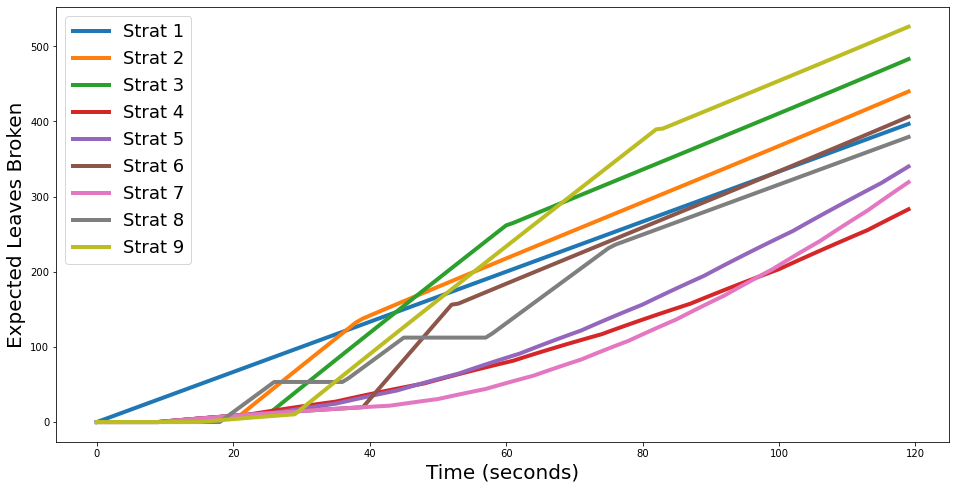

In [18]:
# Plotting all graphs
plt.figure(figsize=(16, 8))
plt.plot(x, strat1_results, label='Strat 1', lw=4)
plt.plot(x, strat2_results, label='Strat 2', lw=4)
plt.plot(x, strat3_results, label='Strat 3', lw=4)
plt.plot(x, strat4_results, label='Strat 4', lw=4)
plt.plot(x, strat5_results, label='Strat 5', lw=4)
plt.plot(x, strat6_results, label='Strat 6', lw=4)
plt.plot(x, strat7_results, label='Strat 7', lw=4)
plt.plot(x, strat8_results, label='Strat 8', lw=4)
plt.plot(x, strat9_results, label='Strat 9', lw=4)
plt.legend(fontsize=18)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Expected Leaves Broken", fontsize=20)

plt.show()

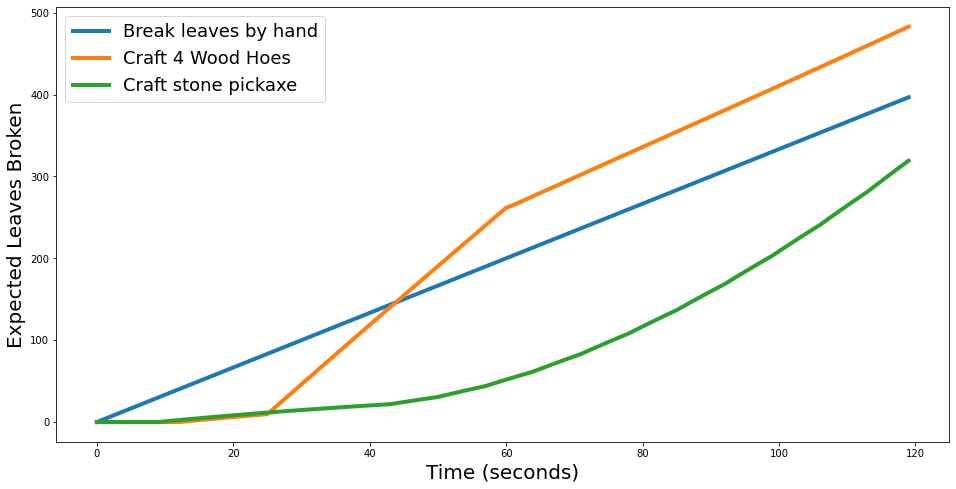

In [19]:
# Important graphs
plt.figure(figsize=(16, 8))
plt.plot(x, strat1_results, label='Break leaves by hand', lw=4)
plt.plot(x, strat3_results, label='Craft 4 Wood Hoes', lw=4)
plt.plot(x, strat7_results, label='Craft stone pickaxe', lw=4)
plt.legend(fontsize=18)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Expected Leaves Broken", fontsize=20)

plt.show()

## Assuming you already have stone tools

#### Late Game Strategy 1
Assume you have as many stone axes as needed, already crafted. Break the top 3 of every tree.

In [20]:
def late_game_strategy_1(num_seconds):
    leaves = []
    tree_decay_starts = [] # keep track of every time a tree starts to decay
    current_t = 0
    
    is_between_trees = False
    
    while current_t < num_seconds:
        # Walk to the next tree if not at one
        if is_between_trees:
            for _ in range(time_between_tree_trunks):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
                is_between_trees = False
        # Break the top three of the tree
        else:
            for _ in range(int(np.ceil(3 * stone_axe_wood_time))):
                decayed_leaves = 0
                for decay_start in tree_decay_starts:
                    decayed_leaves += expected_leaves_decayed(avg_leaves_per_tree, current_t - decay_start)
                leaves.append(decayed_leaves)
                current_t += 1
                if current_t == num_seconds:
                    return leaves
            tree_decay_starts.append(current_t)
    
    return leaves

#### Late Game Strategy 2
Assume you have as many stone hoes as needed, break leaves with them.

In [21]:
def late_game_strategy_2(num_seconds):
    leaves = []
    current_t = 0
    
    while current_t < num_seconds:
        broken_leaves = current_t / stone_hoe_leaf_time
        leaves.append(broken_leaves)
        current_t += 1
    
    return leaves

#### Late Game Strategy 3

Assume you have 9 TNT from a desert temple, a flint and steel, and a stack of blocks. Build up into trees, and place a tnt on top.

In [26]:
def late_game_strategy_3(num_seconds):
    leaves = []
    current_t = 0
    
    num_tnt = 9
    broken_leaves = 0
    tnt_placed_time = -1
    time_until_placement = time_to_place_tnt
    while current_t < num_seconds and num_tnt > 0:
        # If a tnt has just blown up
        if tnt_placed_time > 0 and current_t - tnt_placed_time == 4:
            broken_leaves += leaves_broken_per_tnt
            
        time_until_placement -= 1
        # If we are ready to place another tnt
        if time_until_placement == 0:
            tnt_placed_time = current_t
            time_until_placement = time_to_place_tnt
            num_tnt -= 1
            
        leaves.append(broken_leaves)
        current_t += 1
    
    # When out of tnt, break leaves by hand
    while current_t < num_seconds:
        broken_leaves += 1.0 / hand_leaf_time
        leaves.append(broken_leaves)
        current_t += 1
    
    return leaves

## Graphing Late Game Strategies

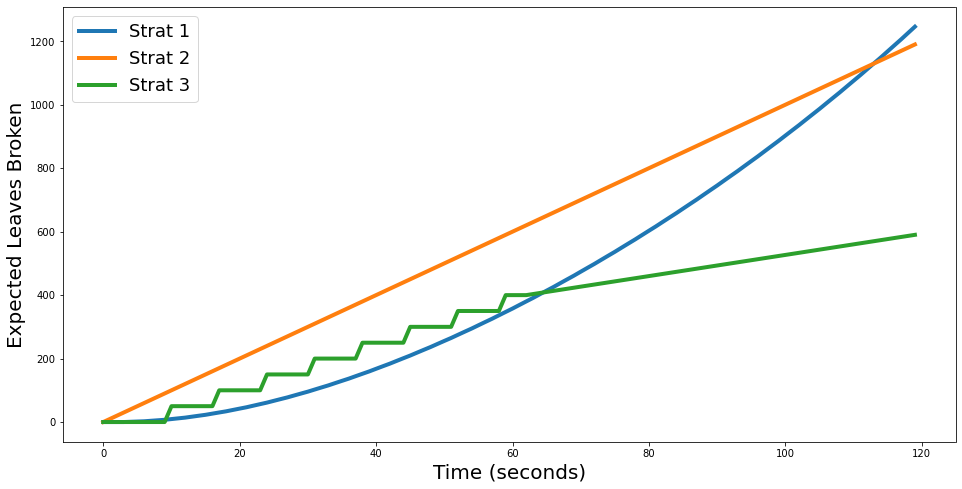

In [27]:
t = 120
late_game_strat1_results = late_game_strategy_1(t)
late_game_strat2_results = late_game_strategy_2(t)
late_game_strat3_results = late_game_strategy_3(t)
x = range(t)

plt.figure(figsize=(16, 8))
plt.plot(x, late_game_strat1_results, label='Strat 1', lw=4)
plt.plot(x, late_game_strat2_results, label='Strat 2', lw=4)
plt.plot(x, late_game_strat3_results, label='Strat 3', lw=4)
plt.legend(fontsize=18)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Expected Leaves Broken", fontsize=20)

plt.show()